In [1]:
%matplotlib inline
from sensor_data_analysis_api import *
import seaborn as sns

C:\Users\User\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 1. Data description

- Number of unique signals = 229
- Number of unique rooms = 253

**1a. Signal distribution based on BACnet types**

- BACnet: Building Automation and Control Network
- 8 different types of BACnet types
- Majority of them are Analog Input and analog Output

**1b. Signal distribution based on Building**

- Almost all the data is in EBU3B building

**1c. Signal distribution based on room**

- Room B102C and server room have highest number of signals

Number of unique signals =  229
Number of unique rooms =  253


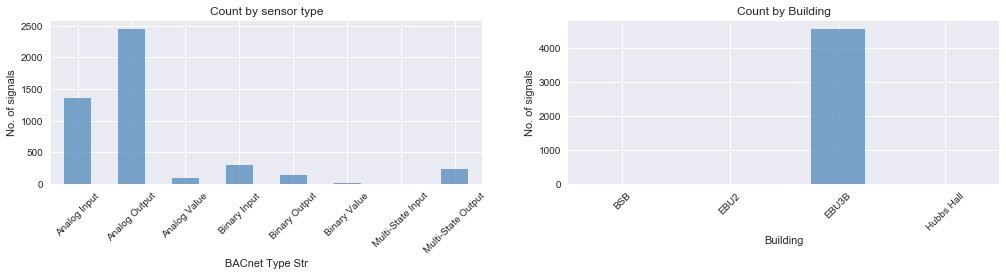

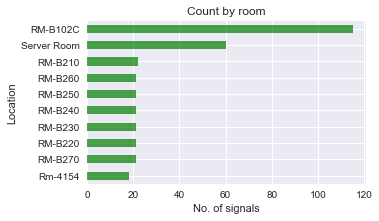

In [2]:
df_metadata = get_df_metadata()
print "Number of unique signals = ", df_metadata['Ground Truth Point Type'].nunique()
print "Number of unique rooms = ", df_metadata['Location'].nunique()

fig, axs = plt.subplots(1, 2, figsize=(17, 3))

df_metadata.groupby('BACnet Type Str')['BACnet Type Str'].count().plot(
    kind='bar', grid=True, alpha=0.7, color='steelblue', rot=45,
    title='Count by sensor type', ax=axs[0]);
axs[0].set(ylabel='No. of signals')

df_metadata.groupby('Building')['Building'].count().plot(
    kind='bar', grid=True, alpha=0.7, color='steelblue', rot=45,
    title='Count by Building', ax=axs[1])
axs[1].set(ylabel='No. of signals')

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
top10_df = df_metadata.groupby(['Location'])['Ground Truth Point Type'].nunique().sort_values(ascending=False).head(10)
top10_df.sort_values(ascending=True).plot(kind='barh', color='green', alpha=0.7, grid=True,
                                                   legend=False, title='Count by room', ax=ax)
ax.set(xlabel='No. of signals');

### 2. Weather data

- Weather data for La Jolla is purchased from https://openweathermap.org/
![weather description](weather_metadata.png)

**2a. Weather data cleanup**

- Remove columns that have all / most nans
- Remove columns that are not applicable (city_id, weather_icon)

columns that are retained are:

1) dt_iso  
2) temp  
3) temp_min  
4) temp_max  
5) pressure  
6) humidity  
7) wind_speed  
8) wind_deg  
9) clouds_all  
10) weather_id  
11) weather_main

**2b. Feature engineering**

1) Conversion of temperature columns from Klevin to farenheit  
2) Label encoding for weather_main

In [3]:
weather_df = get_df_weather()
weather_df.head(3)

,dt_iso,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,date,hour
0,2012-10-01 06:00:00,65.318,62.006,75.992,1013,59,1,60,1,800,0,2012-10-01,6
1,2012-10-01 07:00:00,64.940,60.008,78.008,1013,55,0,0,3,721,4,2012-10-01,7
2,2012-10-02 08:00:00,69.422,60.800,82.004,1014,56,1,340,3,721,4,2012-10-02,8


### 3. Understanding the signal data

- Zone temperature for each day (monday - sunday) for Room 3114 accross years is plotted.
- This is to see the high level behavior / variance.

**Observations**

- Weekend's behavior is different than week day as expected.
- Saturday and Sunday has higher zone temperature values in summers than in winters as expected.
- Zone temperature for week days is almost uniform accross summers and winters probably due to air conditioning.

**conclusion**

- Week day is very important factor and is worth modelling separately for each day of week.

Read file:  506_0_3003116.csv


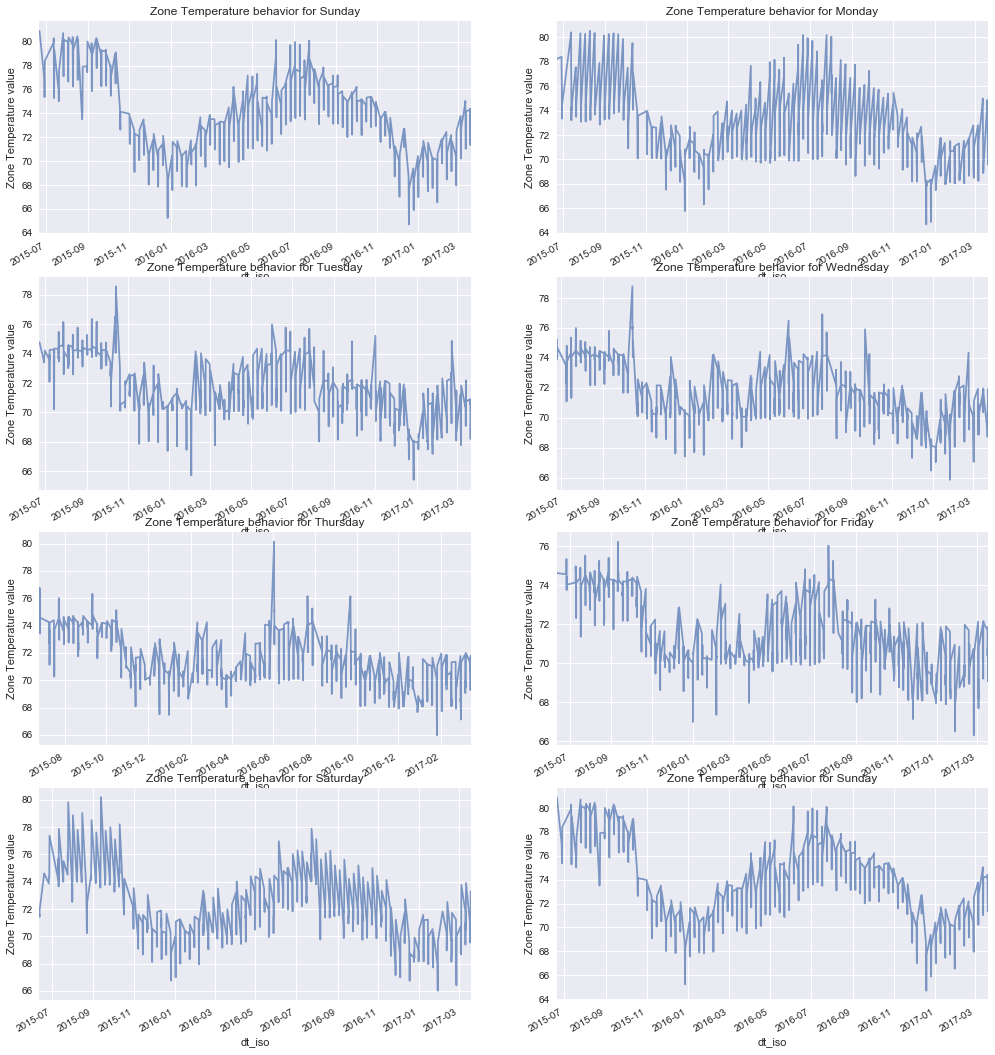

In [4]:
room = 'Rm-3114'
signals= ["Zone Temperature"]
model_df = get_signal_dataframe(room, signals)

# Filter the data from june 2015
model_filtered = model_df[model_df.dt_iso > pd.to_datetime("2015-06-01")]

fig, axs = plt.subplots(4, 2, figsize=(17, 20))

def plot_graph(model_filtered, ax, day, signal):
    model_filtered[model_filtered.dt_iso.dt.weekday_name == day].set_index('dt_iso')[['Zone Temperature']].plot(
        grid=True, alpha=0.7, ax=ax, legend=False)
    ax.set_title(signal + " behavior for " + day)
    ax.set(ylabel = signal + " value")

plot_graph(model_filtered, axs[0][0], "Sunday", "Zone Temperature")
plot_graph(model_filtered, axs[0][1], "Monday", "Zone Temperature")
plot_graph(model_filtered, axs[1][0], "Tuesday", "Zone Temperature")
plot_graph(model_filtered, axs[1][1], "Wednesday", "Zone Temperature")
plot_graph(model_filtered, axs[2][0], "Thursday", "Zone Temperature")
plot_graph(model_filtered, axs[2][1], "Friday", "Zone Temperature")
plot_graph(model_filtered, axs[3][0], "Saturday", "Zone Temperature")
plot_graph(model_filtered, axs[3][1], "Sunday", "Zone Temperature")

### 4. Modelling for Zone temperature

**What:** Model the room 3114 for each week day based on external weather parameters. Predict the Zone temperature value based on weather features.

**Procedure:**

- Get the Zone temperature data for room 3114 (zone temperature is recorded every 5 minutes)  
- Create the hour feature from datetime field.  
- Average the Zone temperature value within each hour (This is needed because weather data is for each hour)  
- Merge the signal data with weather data (features for model) on date time field (This is inner join and so we may loose some data).  
- Filter the data for a specific day of week (Ex:- Sunday)
- Split the data into training and testing set (66% training, 33% testing)  
- Train the data (weather data columns are features and zone temperature is target variable) using various models (ridge, Lasso, AdaBoostRegressor, DecisionTreeRegressor)
- Predict the zone temperature on the testing set.
- Print the scores (coefficient of determination R^2 of the prediction) with various models for training and testing.

**Results**

- DecisionTreeRegressor performs best on training data (not surprised)
- AdaBootRegressor performs well on testing data.
- External Weather is very important in determining the zone temperature.

In [5]:
room = 'Rm-3114'
signals = ["Zone Temperature", 'Supply Airflow']
features = ['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg',
        'clouds_all', 'weather_id', 'weather_main', 'hour']
day = "Sunday"
target = "Zone Temperature"

model_df = get_signal_dataframe(room, signals, mean_type="hour", use_weather_data=True)
model_for_day(model_df, features, target)

Read file:  506_0_3003116.csv
Read file:  506_0_3003122.csv


,model,test score,train score
0,DecisionTreeRegressor,0.777367,0.783654
1,LinearRegression,0.803248,0.740135
2,Lasso,0.813416,0.738179
3,Ridge,0.803258,0.740146
4,AdaBoostRegressor,0.820211,0.781733


### 5. Modelling for Supply airflow

**What:** Model the room 3114 for each week day based on external weather parameters. Predict the Supply airflow value based on weather features and zone temperature.

**Procedure:**

- Followed the same procedure as above (for zone temperature). (Weather data as features and supply airflow as target variable)
- The model score is very bad with the weather only features.
- Used zone temperature as feature along with weather data and predicted the supply airflow.
- Got better scores (But should be improved).
- Zone temperature is very important in deciding the supply airflow.

**Results**

- DecisionTreeRegressor performs best on training data (not surprised)  
- AdaBootRegressor performs well on testing data.  
- Supply airflow is largely dependent on Zone temperature.

In [6]:
room = 'Rm-3114'
signals = ["Zone Temperature", 'Supply Airflow']
features = ['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg',
        'clouds_all', 'weather_id', 'weather_main', 'hour', "Zone Temperature"]
day = "Sunday"
target = 'Supply Airflow'

model_df = get_signal_dataframe(room, signals, mean_type="hour", use_weather_data=True)
model_for_day(model_df, features, target)

Read file:  506_0_3003116.csv
Read file:  506_0_3003122.csv


,model,test score,train score
0,DecisionTreeRegressor,0.770702,0.668926
1,LinearRegression,0.239281,0.251510
2,Lasso,0.231818,0.243795
3,Ridge,0.239204,0.251497
4,AdaBoostRegressor,0.680252,0.791127


In [7]:
room = 'Rm-3114'
signals = ["Zone Temperature", 'Supply Airflow']
features = ['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg',
        'clouds_all', 'weather_id', 'weather_main', 'hour', "Zone Temperature"]
day = "Sunday"
target = 'Supply Airflow'

model_df = get_signal_dataframe(room)
model_df.head()

Read file:  506_0_3003116.csv
Read file:  506_0_3003122.csv
Read file:  506_0_3003120.csv
Read file:  506_0_3003119.csv
Read file:  506_0_3003121.csv
Read file:  506_1_3003124.csv
Read file:  506_1_3015731.csv
Read file:  506_1_3003126.csv
Read file:  506_1_3003123.csv
Read file:  506_1_3003129.csv
Read file:  506_1_3003128.csv
Read file:  506_1_3003131.csv
Read file:  506_1_3003125.csv
Read file:  506_1_3003127.csv
Read file:  506_1_3003130.csv
Read file:  506_14_3003134.csv


,dt_iso,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,...,Maximum Supply Airflow,Minimum Occupied Cooling Supply Airflow,Minimum Occupied Heating Supply Airflow,Occupancy Command,Reheat Valve Command,Supply Airflow,Supply Airflow Setpoint,Temperature Setpoint,Warm Cool Adjust,Zone Temperature
0,2014-01-01 00:00:00,64.940,59.000,71.006,1029,71,0,225,56,803,...,770.0,235.0,235.0,3.000000,0.0,238.939375,235.0,72.0,0.3,64.9025
1,2014-01-01 01:00:00,61.052,57.002,64.994,1029,71,0,261,56,803,...,770.0,235.0,235.0,3.000000,0.0,237.020667,235.0,72.0,0.3,64.5900
2,2014-01-01 02:00:00,57.092,53.996,60.008,1030,71,2,281,56,701,...,770.0,235.0,235.0,3.000000,0.0,236.343750,235.0,72.0,0.3,64.5900
3,2014-01-01 03:00:00,54.536,51.998,57.002,1030,71,1,351,56,741,...,770.0,235.0,235.0,2.882353,0.0,235.423333,235.0,72.0,0.3,64.5900
4,2014-01-01 04:00:00,52.466,48.002,57.002,1030,71,0,13,56,701,...,770.0,235.0,235.0,3.000000,0.0,234.556875,235.0,72.0,0.3,64.3400


In [8]:
new_columns = model_df.columns.difference(['dt_iso', 'time', 'location', 'date', 'hour'])
new_df = model_df.dropna()[new_columns]

variance_threshold = VarianceThreshold(0.2)
transformed = variance_threshold.fit_transform(new_df)

selected_columns = new_df.columns[variance_threshold.get_support(False)]
new_df = pd.DataFrame(transformed, columns=selected_columns)
corr_matrix = np.corrcoef(new_df.T.values)

corr_df = pd.DataFrame(corr_matrix, index=selected_columns, columns=selected_columns) 
corr_df

,Actual Cooling Setpoint,Actual Heating Setpoint,Cooling Command,Damper Position,Heating Command,Occupancy Command,Reheat Valve Command,Supply Airflow,Supply Airflow Setpoint,Temperature Setpoint,...,clouds_all,humidity,pressure,temp,temp_max,temp_min,weather_id,weather_main,wind_deg,wind_speed
Actual Cooling Setpoint,1.000000,-0.771631,-0.179836,-0.846253,-0.219864,-0.899052,-0.153429,-0.848965,-0.828835,0.230590,...,0.002098,0.238368,0.056300,-0.155859,-0.140824,-0.184396,0.001598,0.017560,-0.008118,-0.169485
Actual Heating Setpoint,-0.771631,1.000000,0.232972,0.904067,0.345017,0.963667,0.282687,0.910749,0.904258,0.169067,...,-0.011631,-0.229600,0.059777,0.293865,0.308209,0.266784,0.047036,-0.037359,0.075521,0.164649
Cooling Command,-0.179836,0.232972,1.000000,0.460558,-0.048099,0.222881,-0.047268,0.488875,0.531399,-0.011933,...,-0.029360,-0.149923,-0.048758,0.287225,0.297074,0.252655,0.029311,-0.026281,0.067397,0.120659
Damper Position,-0.846253,0.904067,0.460558,1.000000,0.288787,0.935501,0.246009,0.939593,0.962085,0.033138,...,-0.015575,-0.257529,0.005751,0.278134,0.284699,0.265266,0.043225,-0.044120,0.050496,0.177439
Heating Command,-0.219864,0.345017,-0.048099,0.288787,1.000000,0.326573,0.510045,0.257046,0.262903,0.234339,...,0.023932,-0.003038,0.136444,-0.133548,-0.100350,-0.157912,0.033076,-0.023213,-0.040141,-0.051250
Occupancy Command,-0.899052,0.963667,0.222881,0.935501,0.326573,1.000000,0.272328,0.933436,0.930930,0.038414,...,-0.005903,-0.244451,0.019155,0.255140,0.258481,0.248406,0.032293,-0.033825,0.051855,0.173301
Reheat Valve Command,-0.153429,0.282687,-0.047268,0.246009,0.510045,0.272328,1.000000,0.196083,0.216069,0.212412,...,-0.007150,-0.036899,0.091488,-0.088704,-0.069816,-0.107995,0.031901,-0.032877,-0.054160,-0.013582
Supply Airflow,-0.848965,0.910749,0.488875,0.939593,0.257046,0.933436,0.196083,1.000000,0.969115,0.000641,...,-0.017113,-0.265894,-0.004182,0.309067,0.314442,0.292232,0.028575,-0.029890,0.065132,0.190901
Supply Airflow Setpoint,-0.828835,0.904258,0.531399,0.962085,0.262903,0.930930,0.216069,0.969115,1.000000,0.024963,...,-0.017210,-0.265069,-0.001832,0.322684,0.328761,0.304753,0.041702,-0.043309,0.066963,0.190295
Temperature Setpoint,0.230590,0.169067,-0.011933,0.033138,0.234339,0.038414,0.212412,0.000641,0.024963,1.000000,...,-0.021616,0.099248,0.151719,0.019309,0.031664,0.009600,0.083776,-0.076724,0.064993,-0.078013


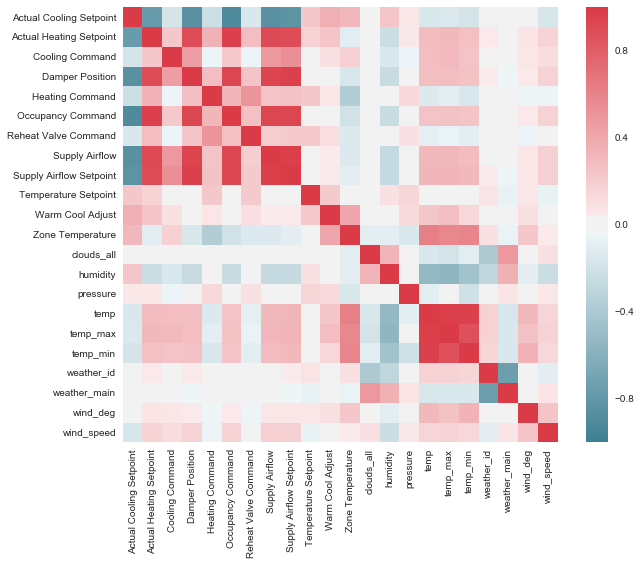

In [9]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_df, mask=np.zeros_like(corr_df, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
           square=True, ax=ax)